## **Initialization and Parameter Setting**

The state of the five edges is represented by **component events**.  
Each edge can take a **binary state**:  
- `0`: Non-functional  
- `1`: Functional  

### **Edge Probabilities**
```python
probs = {
    'e1': {0: 0.01, 1: 0.99},
    'e2': {0: 0.01, 1: 0.99},
    'e3': {0: 0.05, 1: 0.95},
    'e4': {0: 0.05, 1: 0.95},
    'e5': {0: 0.10, 1: 0.90}
}

In [55]:
import gc
import itertools
import numpy as np
import networkx as nx
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from itertools import combinations
from networkx.algorithms.flow import shortest_augmenting_path
from mbnpy import brc, cpm, variable, operation, branch, config, trans
import pandas as pd
# Clean up memory
gc.collect()
%matplotlib inline


In [56]:

# Define the network
nodes = {'n1': (0, 0),
         'n2': (1, 1),
         'n3': (1, -1),
         'n4': (2, 0)}

edges = {'e1': ['n1', 'n2'],
         'e2': ['n1', 'n3'],
         'e3': ['n2', 'n3'],
         'e4': ['n2', 'n4'],
         'e5': ['n3', 'n4']}

probs = {'e1': {0: 0.01, 1: 0.99}, 'e2': {0: 0.01, 1: 0.99}, 'e3': {0: 0.05, 1: 0.95},
         'e4': {0: 0.05, 1: 0.95}, 'e5': {0: 0.10, 1: 0.90}}

## **Functions for Reliability Index and Redundancy Index**
#### **Beta Calculation**
$$
\beta_{ij} = -\Phi^{-1}\left(P(F_i \mid H_j)\right)
$$

In [57]:
def calculate_beta(probs):
    # Calculate beta for individual components
    beta = {}
    for edge, probabilities in probs.items():
        failure_prob = probabilities[0]  # P(F_i)
        beta[edge] = -norm.ppf(failure_prob)  # β_i = -Φ^(-1)(P(F_i))

    # Print individual beta values
    print("\nBeta values for each edge:")
    for edge, beta_value in beta.items():
        print(f"Edge {edge}: Beta = {beta_value:.5f}")

    # Define correlation coefficient matrix for n components
    num_edges = len(probs)
    corr_coeff = 0  # Example correlation coefficient
    correlation_matrix = np.full((num_edges, num_edges), corr_coeff)
    np.fill_diagonal(correlation_matrix, 1)  # Diagonal elements are 1

    # Map edge indices to edge names
    edge_names = list(probs.keys())

    # Extract beta values as a list
    beta_values = list(beta.values())

    # Store results
    beta_results = []
    state_combinations = []
    failure_probabilities = []

    # Step 1: Add single-edge failures
    for i, edge in enumerate(edge_names):
        failure_prob = probs[edge][0]  # Failure probability
        beta_value = beta[edge]       # Beta value
        beta_results.append(([edge], failure_prob, beta_value))
        state_combinations.append([edge])
        failure_probabilities.append(failure_prob)

    # Step 2: Add combinations of 2 or more edge failures
    for k in range(2, num_edges + 1):  # From 2 components failing to all components
        all_combinations = list(combinations(range(num_edges), k))

        for combo in all_combinations:
            beta_k = np.array([beta_values[i] for i in combo])  # Select beta values for this combination
            mean = np.zeros(k)
            cov = correlation_matrix[np.ix_(combo, combo)]  # Submatrix for the selected combination

            # Calculate P(F^k) for this combination
            prob_joint_failure = multivariate_normal.cdf(-beta_k, mean=mean, cov=cov)
            beta_joint_k = -norm.ppf(prob_joint_failure) if prob_joint_failure > 0 else float('inf')

            # Map indices to edge names for the state
            combo_edges = [edge_names[i] for i in combo]

            # Append results
            beta_results.append((combo_edges, prob_joint_failure, beta_joint_k))
            state_combinations.append(combo_edges)
            failure_probabilities.append(prob_joint_failure)

    # Print results for each combination
    print("\nAll beta values for combinations:")
    for state, prob, beta_value in beta_results:
        print(f"Combination {state}: Failure Probability = {prob:.5e}, Beta = {beta_value:.5f}")

    return beta_results, state_combinations, failure_probabilities

- **MCS이용한 방법과 beta 결과 비교** - 거의 동일하게 나옴

모두 fail한 경우 [0,0,0,0,0]의 베타값이 차이가 좀 크게 나옴
이유 : MCS의 경우 케이스 별 확률 값에 비례하게 sampling되는데 해당 케이크스의 경우 Pf=0.0000000250로, 한 번도 샘플링되지 않음 -> 튀어보이는 결과 도출

In [58]:
beta_results, state_combinations, failure_probabilities = calculate_beta(probs)
df_beta_results = pd.DataFrame(beta_results, columns=['State', 'Failure Probability', 'Beta'])
print(df_beta_results.to_string(index=False)) 


Beta values for each edge:
Edge e1: Beta = 2.32635
Edge e2: Beta = 2.32635
Edge e3: Beta = 1.64485
Edge e4: Beta = 1.64485
Edge e5: Beta = 1.28155

All beta values for combinations:
Combination ['e1']: Failure Probability = 1.00000e-02, Beta = 2.32635
Combination ['e2']: Failure Probability = 1.00000e-02, Beta = 2.32635
Combination ['e3']: Failure Probability = 5.00000e-02, Beta = 1.64485
Combination ['e4']: Failure Probability = 5.00000e-02, Beta = 1.64485
Combination ['e5']: Failure Probability = 1.00000e-01, Beta = 1.28155
Combination ['e1', 'e2']: Failure Probability = 1.00000e-04, Beta = 3.71902
Combination ['e1', 'e3']: Failure Probability = 5.00000e-04, Beta = 3.29053
Combination ['e1', 'e4']: Failure Probability = 5.00000e-04, Beta = 3.29053
Combination ['e1', 'e5']: Failure Probability = 1.00000e-03, Beta = 3.09023
Combination ['e2', 'e3']: Failure Probability = 5.00000e-04, Beta = 3.29053
Combination ['e2', 'e4']: Failure Probability = 5.00000e-04, Beta = 3.29053
Combination

#### **Pi Calculation**

$$
\begin{align*}
\pi_{ij} & = -\Phi^{-1}\left(P(F_{\text{sys}} \mid F_i, H_j)\right) \\
         & = -\Phi^{-1}\left(\frac{P(F_{\text{sys}}, F_i)}{P(F_i)}\right) \\
         & = -\Phi^{-1}\left(
         \frac{
         \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 0} p
         + \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 1 \text{ and } \boldsymbol{l}\langle X_i \rangle = 0} \left(p \cdot P(F_i)\right)
         + \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 1 \text{ and } \boldsymbol{l}\langle X_i \rangle = 1} 0
         }{P(F_i)}
         \right)
\end{align*}
$$

- ***System event***

System state is evaluated by network connectivity between a designed origin-destination (OD) pair. <br>
In other words, a system state is survival if the OD pair is connected; and failure otherwise.

In [59]:
def net_conn(comps_st, od_pair, edges, varis): # maximum flow analysis

    G = nx.Graph()
    for k,x in comps_st.items():
        G.add_edge(edges[k][0], edges[k][1]) # we add each edge
        G[edges[k][0]][edges[k][1]]['capacity'] = varis[k].values[x] # define capacity as 0 if state = 0 or 1 if state = 1

    # perform maximum flow analysis between the OD pair
    G.add_edge(od_pair[1], 'new_d', capacity=1) # add a new edge with capacity 1 to ensure we find only ONE path. 
    f_val, f_dict = nx.maximum_flow(G, od_pair[0], 'new_d', capacity='capacity', flow_func=shortest_augmenting_path)

    if f_val > 0: # if the flow between the OD pair is greater than 0, the two nodes are connected
        sys_st = 's'

        # We can infer an associated minimum survival rule in case of network connectivity.
        min_comps_st = {} 
        for k, x in comps_st.items():
            k_flow = max([f_dict[edges[k][0]][edges[k][1]], f_dict[edges[k][1]][edges[k][0]]])
            if k_flow > 0: # the edges with flows > 0 consitute a minimum survival rule.
                min_comps_st[k] = 1

    else:
        sys_st = 'f'

        # In case of system failure, obtaining a minimum failure rule is not straightforward.
        min_comps_st = None

    return f_val, sys_st, min_comps_st

In this example, we consider the OD pair 'n1' and 'n4'.

In [60]:
od_pair=('n1','n4')

To run the BRC algorithm, a system function needs to have only one input **components state.**

This can be done using a lambda function.

In [61]:
sys_fun = lambda comps_st : net_conn(comps_st, od_pair, edges, varis)

- **Application of the BRC Algorithm**

In [62]:
brs, rules, sys_res, monitor = brc.run(
    probs=probs, 
    sys_fun=sys_fun, 
    max_sf=np.inf, 
    max_nb=np.inf, 
    pf_bnd_wr=0.0, 
    max_rules=100,  
    active_decomp=10,
    display_freq=5,
    brs=[],
)
print(brs)

print(rules)

[System function runs 5]..
The # of found non-dominated rules (f, s): 5 (1, 4)
Probability of branchs (f, s, u): (5.0000e-03, 9.94e-01, 5.9202e-04)
The # of branches (f, s, u), (min, avg) len of rf: 12 (4, 4, 4), (2, 2.00)
Elapsed seconds (average per round): 7.00e-03 (1.40e-03)

*Final decomposition is completed with 11 branches (originally 13 branches).

***Analysis completed with f_sys runs 8: out_flag = complete***
The # of found non-dominated rules (f, s): 8 (4, 4)
Probability of branchs (f, s, u): (5.1688e-03, 9.95e-01, 0.0000e+00)
The # of branches (f, s, u), (min, avg) len of rf: 11 (5, 6, 0), (2, 2.50)
Elapsed seconds (average per round): 1.20e-02 (1.33e-03)
[Branch(
  down={'e1': 1, 'e2': 0, 'e3': 0, 'e4': 1, 'e5': 0},
  up={'e1': 1, 'e2': 1, 'e3': 1, 'e4': 1, 'e5': 1},
  down_state='s',
  up_state='s',
  p=0.9405
), Branch(
  down={'e1': 1, 'e2': 1, 'e3': 0, 'e4': 0, 'e5': 1},
  up={'e1': 1, 'e2': 1, 'e3': 1, 'e4': 0, 'e5': 1},
  down_state='s',
  up_state='s',
  p=0.0441045

- **Pi calculation**

In [63]:
def calculate_pi(brs, probs, beta_results):
    results = {}
    
    # Initialize variables
    components = list(probs.keys())  # List of all components
    state_combinations = []  # List to store N_c for each failure combination
    
    # Generate combinations of failure components
    for r in range(1, len(components) + 1):  # r: number of failed components
        failure_combinations = list(itertools.combinations(components, r))
        state_combinations.extend(failure_combinations)

    results["Failure Combinations"] = state_combinations

    # Parse branches to identify B_f (failure branches)
    B_f = [branch for branch in brs if branch.down_state == 'f']
    results["B_f"] = B_f

    sys_comp_fail_prob = []

    for combination in state_combinations:
        branch_probability = 0
        expression_terms = []  # To store terms as strings

        # Filter branches where all components in the combination have down bound == 0
        filtered_B_f = [
            branch for branch in B_f
            if all(branch.down.get(component, 1) == 0 for component in combination)
        ]

        for branch in filtered_B_f:
            l_states = branch.down
            u_states = branch.up
            p_branch = branch.p

            # 1. Case: All components in combination satisfy u == 0
            if all(u_states.get(component, 1) == 0 for component in combination):
                branch_probability += p_branch
                expression_terms.append(f"{p_branch}")

            # 2. Case: Some components have u == 1 and l == 0
            else:
                # Identify components with u == 1 and l == 0
                relevant_components = [
                    component for component in combination
                    if u_states.get(component, 1) == 1 and l_states.get(component, 0) == 0
                ]

                if relevant_components:
                    # Compute failure probability product
                    failure_prob_product = np.prod([probs[comp][0] for comp in relevant_components])

                    # Calculate the term
                    term = p_branch * failure_prob_product
                    branch_probability += term
                    expression_terms.append(f"{p_branch} * prod({[probs[c][0] for c in relevant_components]})")

        sys_comp_fail_prob.append(branch_probability)

        # Print the branch probability as an expression
        expression = " + ".join(expression_terms)
        print(f"Combination: {combination}, Branch Probability = {expression} = {branch_probability}\n")

    results["sys_comp_fail_prob"] = sys_comp_fail_prob



    # Calculate P(F_sys, F_i) / P(F_i)
    pi_ratio = []
    for idx, combination in enumerate(state_combinations):
        failure_prob_product = np.prod([probs[comp][0] for comp in combination])
        
        # Use the corresponding value from sys_comp_fail_prob for the numerator
        numerator = sys_comp_fail_prob[idx]  # Get the specific branch probability for this combination
        
        if failure_prob_product > 0:
            denominator = failure_prob_product
            ratio = numerator / denominator
            
            # Print the calculation
            print(f"Combination: {combination}, Calculation: {numerator} / {denominator} = {ratio}")
        else:
            ratio = float('inf')
            print(f"Combination: {combination}, Calculation: Division by zero, Ratio = inf")

        pi_ratio.append((combination, ratio))

    results["pi_ratio"] = pi_ratio



    # Calculate π_ij = -Φ^(-1)(P(F_sys | F_i, H_j))
    pi_results = []
    for combination, ratio in pi_ratio:
        if ratio >= 1 and ratio < 1.01:
            # Handle ratios slightly above 1 by capping π_ij to -3
            pi_ij = -3
            print(f"Adjusted ratio for {combination} in range [1, 1.01) to π_ij = -3")
        elif ratio >= 1.01:
            # For larger ratios, handle as NaN or inf
            pi_ij = float('inf')
            print(f"Warning: Ratio for {combination} exceeds 1.01, setting π_ij to inf")
        elif ratio <= 0:
            pi_ij = float('inf')  # Handle invalid or zero ratio
            print(f"Warning: Ratio for {combination} is zero or negative, setting π_ij to inf")
        else:
            # Normal calculation for valid ratios
            pi_ij = -norm.ppf(ratio)
            if pi_ij < -3:
                pi_ij = -3  # Cap minimum value to -3
                print(f"Adjusted π_ij for {combination} to -3")

        pi_results.append({
            'State': combination,
            'P(Fsys | state)': ratio,
            'π_ij': pi_ij
        })



    return pi_results  # Only return the relevant results for DataFrame conversion



Beta values for each edge:
Edge e1: Beta = 2.32635
Edge e2: Beta = 2.32635
Edge e3: Beta = 1.64485
Edge e4: Beta = 1.64485
Edge e5: Beta = 1.28155

All beta values for combinations:
Combination ['e1']: Failure Probability = 1.00000e-02, Beta = 2.32635
Combination ['e2']: Failure Probability = 1.00000e-02, Beta = 2.32635
Combination ['e3']: Failure Probability = 5.00000e-02, Beta = 1.64485
Combination ['e4']: Failure Probability = 5.00000e-02, Beta = 1.64485
Combination ['e5']: Failure Probability = 1.00000e-01, Beta = 1.28155
Combination ['e1', 'e2']: Failure Probability = 1.00000e-04, Beta = 3.71902
Combination ['e1', 'e3']: Failure Probability = 5.00000e-04, Beta = 3.29053
Combination ['e1', 'e4']: Failure Probability = 5.00000e-04, Beta = 3.29053
Combination ['e1', 'e5']: Failure Probability = 1.00000e-03, Beta = 3.09023
Combination ['e2', 'e3']: Failure Probability = 5.00000e-04, Beta = 3.29053
Combination ['e2', 'e4']: Failure Probability = 5.00000e-04, Beta = 3.29053
Combination

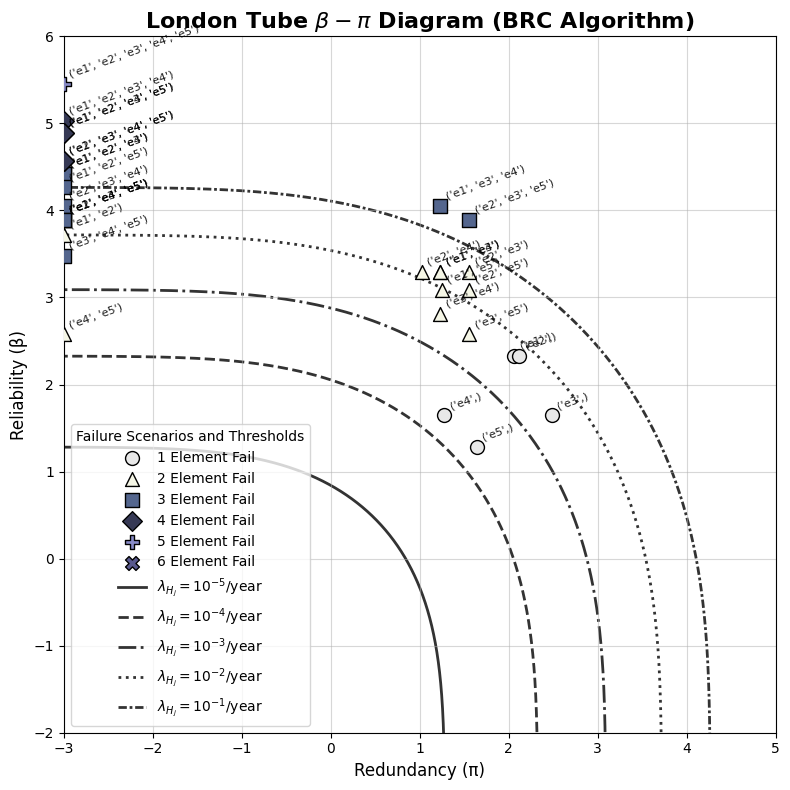

In [64]:
# Step 1: β calculation
beta_results, state_combinations, failure_probabilities = calculate_beta(probs)
df_beta_results = pd.DataFrame(beta_results, columns=['State', 'Failure Probability', 'Beta'])

# Step 2: π calculation
pi_results = calculate_pi(brs, probs, beta_results)
df_pi_results = pd.DataFrame(pi_results)

# Step 3: Generate β-π Diagram
# Input β and π values
beta_values = df_beta_results['Beta'].values
pi_values = df_pi_results['π_ij'].values
state_labels = df_pi_results['State'].values  # MECE state labels

# Count the number of failed edges
failed_elements = [len(state) for state in state_labels]  # Calculate the number of failed edges in each state


# 색상 및 마커 설정
colors = [(232/255, 232/255, 232/255),
          (245/255, 246/255, 230/255),   
          (84/255, 102/255, 142/255),    
          (54/255, 57/255, 85/255), 
          (135/255, 138/255, 198/255),     
          (89/255, 89/255, 142/255)]   

markers = ['o', '^', 's', 'D', 'P', 'X']  

# Plot 설정
plt.figure(figsize=(8, 8))  # Set the overall plot size

# 각 실패 요소별로 점 그리기
for count, color, marker in zip([1, 2, 3, 4, 5, 6], colors, markers):
    indices = [i for i, x in enumerate(failed_elements) if x == count]
    plt.scatter(np.array(pi_values)[indices], np.array(beta_values)[indices],
                color=color, s=100, label=f"{count} Element Fail",
                marker=marker, edgecolors='k', alpha=1.0, zorder=3)
    
    # 각 점 옆에 state label 추가
    for idx in indices:
        plt.text(pi_values[idx]+0.05, beta_values[idx]+0.05, state_labels[idx],
                 fontsize=8, ha='left', va='bottom', rotation=20, alpha=0.9)


# Threshold lines for the β-π Diagram
prob_targets = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reverse_labels = [r'$\lambda_{H_j} = 10^{-5}$/year', r'$\lambda_{H_j} = 10^{-4}$/year',
                  r'$\lambda_{H_j} = 10^{-3}$/year', r'$\lambda_{H_j} = 10^{-2}$/year',
                  r'$\lambda_{H_j} = 10^{-1}$/year']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]

for prob_target, line_style, label in zip(prob_targets, line_styles, reverse_labels):
    beta_threshold = np.arange(-3, 8, 1e-4)  # Optimize step size
    pi_threshold = -norm.ppf(prob_target / norm.cdf(-beta_threshold))
    plt.plot(pi_threshold, beta_threshold, 'black', linestyle=line_style,
             linewidth=2, label=label, alpha=0.8, zorder=1)

# Plot 커스터마이징
plt.title(r'London Tube $\beta - \pi$ Diagram (BRC Algorithm)', fontsize=16, fontweight='bold')
plt.xlabel('Redundancy (π)', fontsize=12)
plt.ylabel('Reliability (β)', fontsize=12)
plt.xlim([-3, 5])
plt.ylim([-2, 6])
plt.grid(alpha=0.5)
plt.legend(title="Failure Scenarios and Thresholds", fontsize=10, loc="best")
plt.tight_layout()
plt.show()

In [65]:
import numpy as np
import pandas as pd

# 데이터 준비 (기존에 정의된 beta_values, pi_values, state_labels 활용)
beta_values = df_beta_results['Beta'].values
pi_values = df_pi_results['π_ij'].values
state_labels = df_pi_results['State'].values

# π >= 0인 데이터만 필터링
indices = np.where(pi_values >= 0)[0]

# 원점(0,0)과의 거리 계산
distances = np.sqrt(beta_values[indices]**2 + pi_values[indices]**2)

# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    'State': state_labels[indices],
    'Beta': beta_values[indices],
    'Pi': pi_values[indices],
    'Distance_from_Origin': distances
})

# 거리가 가까운 순으로 정렬
sorted_results_df = results_df.sort_values(by='Distance_from_Origin')

# 결과 확인
sorted_results_df.reset_index(drop=True, inplace=True)
sorted_results_df


,State,Beta,Pi,Distance_from_Origin
0,"(e5,)",1.281552,1.639398,2.080865
1,"(e4,)",1.644854,1.278506,2.083296
2,"(e3,)",1.644854,2.484565,2.979699
3,"(e3, e5)",2.575829,1.558985,3.010869
4,"(e3, e4)",2.807034,1.231864,3.065441
5,"(e1,)",2.326348,2.060979,3.107979
6,"(e2,)",2.326348,2.115880,3.144653
7,"(e1, e5)",3.090232,1.245222,3.331683
8,"(e2, e4)",3.290527,1.021326,3.445384
9,"(e2, e5)",3.090232,1.558985,3.461209
